# Setup

## Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from trendmaster import trend
import itertools
from scipy.stats import linregress
import datetime
import pickle
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon

## Other

In [2]:
def saveDict(dictionary,filename):
    """
    Saves dictionary to pickle file in working directory.
    
    Parameters
    ----------
    dictionary: dict
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    Nothing
    """
    f = open(f"{filename}.pkl","wb")
    pickle.dump(dictionary,f)
    f.close()

def openDict(filename):
    """
    Opens dictionary from pickle file in working directory.
    
    Parameters
    ----------
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    dictionary
    """
    pickle_in = open(f"{filename}.pkl","rb")
    loadedDict = pickle.load(pickle_in)
    return loadedDict

# Metadata table

In [3]:
# load table of metadata, i.e. final station selection of Vormoor et al.
catchm = pd.read_csv("final_station_selection.txt",header=0,sep="\t")
df = pd.DataFrame(catchm)

# adding information from NEVINA
df.loc[df.snumber==200607,"areal"] = 126.41 #must be removed
df.loc[df.snumber==200607,"altitude"] = 933 #must be removed
df.loc[df.snumber==8400020,"areal"] = 5.14
df.loc[df.snumber==8400020,"altitude"] = 673
df.loc[df.snumber==2400008,"areal"] = 121
df.loc[df.snumber==2400008,"altitude"] = 325 #Hmin change to H50!

In [4]:
feltparam = pd.read_csv("feltparam.txt",header=0,sep="\t", usecols=[0,2,7,12,17,20,21,24,25,26,27,28])

In [5]:
df["BREPRO"] = np.nan
for c in df.snumber:
    cpad = int(str(c)+"000")
    val = float(feltparam.loc[feltparam.SNUMBER==cpad,"BREPRO"].mean())
    df.loc[df.snumber==c,"BREPRO"] = val

In [6]:
# some stats
runoffRegion = df["runoff.region"].unique()
print("Regions",runoffRegion)
regionNames = ["Østlandet","Sørlandet","Vestlandet","Trøndelag","Nordland","Finnmark"]
print("Highest station:",df["altitude"].max())
print("Lowest station:",df["altitude"].min())
print("Missing years:",df["missing.yr"].unique())
print("Shortest timeseries from",df["start.yr"].max())
print("Longest timeseries from",df["start.yr"].min())

Regions ['ostlandet' 'sorlandet' 'vestlandet' 'trondelag' 'nordland' 'finnmark']
Highest station: 1546.0
Lowest station: 25.0
Missing years: [0 1 3 4 2 6 5]
Shortest timeseries from 1982
Longest timeseries from 1960


Text(0,0.5,'Altitude')

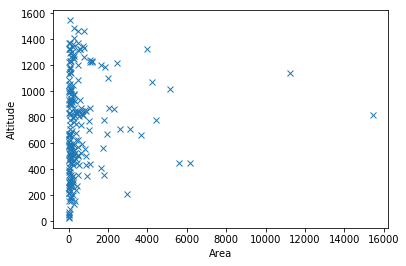

In [7]:
df["altitude"].plot.hist()
plt.close()

plt.figure()
df["missing.yr"].plot.hist()
plt.close()

plt.figure()
plt.plot(df["lon"],df["lat"],"x")
plt.close()

plt.figure()
plt.plot(df["areal"],df["altitude"], "x")
plt.xlabel("Area")
plt.ylabel("Altitude")
#plt.close()

## Splitting by region
Splitting by region and sorting


In [8]:
def byRegion(data,region):
    # select region from df
    regionData = data[data["runoff.region"]==region]
    # sort by altitude, high to low
    regionData = regionData.sort_values("altitude",ascending=False)
    # add station number according to altitude (for plotting later)
    regionData["station.order"]=np.arange(regionData.shape[0],0,-1)
    return regionData

In [9]:
ostlandet = byRegion(df,"ostlandet")
vestlandet = byRegion(df,"vestlandet")
sorlandet = byRegion(df,"sorlandet")
trondelag = byRegion(df,"trondelag")
nordland = byRegion(df,"nordland")
finnmark = byRegion(df,"finnmark")

regionDF = [ostlandet,sorlandet,vestlandet,trondelag,nordland,finnmark]
regions = dict(zip(runoffRegion,regionDF))
regionLabels = dict(zip(runoffRegion,regionNames))

# Importing data

## Organising data

In [10]:
def readRunoff(catchmentNo):
    # reading data
    runoff = pd.read_csv(f"runoff/{catchmentNo}.txt",
                         header=None, sep=" ", names=["date","runoff"],usecols=[0,1],index_col=0)
    # converting indices to datetime objects
    runoff.index = pd.to_datetime(runoff.index)
    # replacing invalid values with nan
    runoff = runoff.replace(-9999.,np.nan)
    return runoff

In [11]:
def readSnow(regine,main):
    # create filepath
    file = f"seNorge/{regine}.{main}/{regine}.{main}_SeNorge_qsw_1959_2014.dta"
    # read file
    snow = pd.read_table(file,delim_whitespace=True,header=None,names=["year","month","day","qsw"])
    # list of dates
    index = list(np.arange(len(snow)))
    for i in range(len(snow)):
        index[i] = f"{snow.year.iloc[i]}-{snow.month.iloc[i]}-{snow.day.iloc[i]}"
    # index as timestamp objects
    snow.index = pd.to_datetime(index)
    # removing unnecessary columns
    snow = snow.drop(["year","month","day"],axis = 1)
    return snow

In [12]:
def readSeNorge(regine,main):
    # create filepath
    file = f"seNorge/{regine}.{main}/{regine}.{main}_SeNorge_rr_tm_1959_2014.dta"
    # read file
    data = pd.read_table(file,delim_whitespace=True,header=None,names=["year","month","day","precip","temp"])
    # list of dates
    index = list(np.arange(len(data)))
    for i in range(len(data)):
        index[i] = f"{data.year[i]}-{data.month[i]}-{data.day[i]}"
    # index as timestamp objects
    data.index = pd.to_datetime(index)
    # removing unnecessary columns
    data = data.drop(["year","month","day"],axis = 1)
    return data

In [13]:
def organiseData(region):
    """
    Organises all data for a region into a dictionary.
    
    Parameters
    -----------
    region: pandas.DataFrame
    
    Returns
    -----------
    dictionary with all variables
    """
    # create dictionary and adds station order by elevation
    d = {"order":list(region.snumber),
         "data":{},
         "metadata":region}
    # add all catchments as keys
    for i in range(region.shape[0]):
        d["data"][region.snumber.iloc[i]] = {}
    
    for c in d["order"]:
        # runoff data for each cathcment
        d["data"][c]["runoff"] = readRunoff(c)
        # snowmelt    
        regine = int(region[region.snumber == c].regine)
        main = int(region[region.snumber == c].main)
        d["data"][c]["snow"] = readSnow(regine,main)
        # precipitation and temperature
        pt = readSeNorge(regine,main)
        d["data"][c]["temp"] = pt.temp
        d["data"][c]["precip"] = pt.precip
        
    # return the finished dictionary
    return d

In [14]:
# set this to True if importing and organising data again
importing = False


if importing:
    # imports and organises data into dictionaries
    ost = organiseData(ostlandet)
    sor = organiseData(sorlandet)
    nord = organiseData(nordland)
    vest = organiseData(vestlandet)
    trond = organiseData(trondelag)
    finn = organiseData(finnmark)
else:
    # opening dictionaries with organised data from file
    sor = openDict("sorlandet_final")
    ost = openDict("ostlandet_final")
    vest = openDict("vestlandet_final")
    trond = openDict("trondelag_final")
    nord = openDict("nordland_final")
    finn = openDict("finnmark_final")

# Visualising data quality

## Runoff quality

In [15]:
start = []
end = []
for station in ost["order"]:
    #print("Station:",station)
    #print("First year:\t",ost['data'][station]['runoff'].index.year[0])
    start.append(ost['data'][station]['runoff'].index.year[0])
    #print("Last year:\t",ost['data'][station]['runoff'].index.year[-1],"\n")
    end.append(ost['data'][station]['runoff'].index.year[-1])

for station in sor["order"]:
    start.append(sor['data'][station]['runoff'].index.year[0])
    end.append(sor['data'][station]['runoff'].index.year[-1])
    
for station in vest["order"]:
    start.append(vest['data'][station]['runoff'].index.year[0])
    end.append(vest['data'][station]['runoff'].index.year[-1])
    
for station in nord["order"]:
    start.append(nord['data'][station]['runoff'].index.year[0])
    end.append(nord['data'][station]['runoff'].index.year[-1])

for station in trond["order"]:
    start.append(trond['data'][station]['runoff'].index.year[0])
    end.append(trond['data'][station]['runoff'].index.year[-1])

for station in finn["order"]:
    start.append(finn['data'][station]['runoff'].index.year[0])
    end.append(finn['data'][station]['runoff'].index.year[-1])

print("Earliest start year:",np.array(start).min())
print("Latest start year:",np.array(start).max())
print("Latest end year",np.array(end).max())
print("Earliest end year",np.array(end).min())

Earliest start year: 1871
Latest start year: 1982
Latest end year 2014
Earliest end year 2012


### Missing days

In [16]:
def missingDays(df):
    a = np.full(144,np.nan)
    years = pd.unique(df.index.year)
    for year in years:
        part = df[str(year)]
        a[year-1871] = part.isnull().sum()[0]
    return a

In [17]:
def missingDaysRegion(data):
    """
    Makes an array of missing days per year per region
    Paramters
    ---------
    data: dictionary
        a dictionary which contains data for a runoff region, especially: 
            data["order"]: the station order 
            data["data"][stationnumber]["runoff"]: runoff for specific station
            
    Returns
    -------
    array of days with missing runoff per year
    """
    a = np.full((len(data["order"]),144),np.nan)
    for i in range(len(data["order"])):
        a[i] = missingDays(data["data"][data["order"][i]]["runoff"])
    
    return a

### Missing years

In [18]:
def missingYears(df):
    """
    Finds gaps of 5 or more values in each year of timeseries. 
    
    Returns
    -------
    array of years with 3 possible values:
        NaN: no data availiable for year
        0: no data gaps in year
        1: one or more gaps of 5 or more missing values found
    """
    a = np.full(144,np.nan)
    years = pd.unique(df.index.year)
    for year in years:
        runoff = df[str(year)].runoff
        n = runoff.isnull().astype(int).groupby(runoff.notnull().astype(int).cumsum()).sum()
        m = n>0 
        if m.any():
            a[year-1871] = 1
        else:
            a[year-1871] = 0
    return a

In [19]:
def missingYearsRegion(data):
    """
    Makes an array of missing days per year per region
    Paramters
    ---------
    data: dictionary
        a dictionary which contains data for a runoff region, especially: 
            data["order"]: the station order 
            data["data"][stationnumber]["runoff"]: runoff for specific station
            
    Returns
    -------
    array of days with missing runoff per year
    """
    a = np.full((len(data["order"]),144),np.nan)
    for i in range(len(data["order"])):
        a[i] = missingYears(data["data"][data["order"][i]]["runoff"])
    
    return a

### Summary

Data is availiable for all catchments from 1982-2012



## seNorge

Appears that files contain *rainfall* and not *precipitation* data

In [20]:
def findMissingSeNorge(data):
    """
    Finds the catchment with missing/problematic seNorge data
    """
    missing = []
    for c in data["order"]:
        if all(data["data"][c]["precip"]==0):
            missing.append(c)
    return missing

In [21]:
def findMissingDays(data,startYear=1983,endYear=2012):
    """
    Identifies catchments which have more than 10% missing data for the chosen period.
    
    Parameters
    ----------
    data: dictionary with organised data for a runoff region
    startYear: beginning of time period
    endYear: end of time period
    
    Returns
    -------
    List of catchment numbers
    """
    start = startYear-1871
    end = endYear-1871
    period = endYear - startYear
    
    arr = missingDaysRegion(data)[:,start:end]
    
    
    # an nan signifies that no data is availiable for that year
    if np.isnan(arr).any():
        print("Warning: Chosen period contains years with no records")
    
    # sum of missing days per catchment
    b = arr.sum(axis=1)
    # identifying catchments with more than 10% missing
    c = (b/(365*period))>0.1
    
    return list(np.array(data["order"])[c])

# Updating metadata table

Using the functions to update metadata table with new values (only for the last 30 years?)

In [22]:
def updateMeta(data,startYear=1983,endYear=2012):
    # resetting indeces
    data["metadata"].reset_index(drop=True,inplace=True)
    
    # seNorge
    data["metadata"]["seNorge"] = 1
    for i in data["metadata"].index:
        if data["metadata"].snumber[i] in findMissingSeNorge(data):
            data["metadata"].loc[i,"seNorge"] = 0
    
    # start and end years
    start = startYear-1871
    end = endYear-1871
    data["metadata"]["missingData30yr"] = np.nan
    for i in data["metadata"].index:
        s = data["metadata"].snumber[i]
        
        # missing data in 30 years
        missing = missingDays(data["data"][s]["runoff"])[start:end].sum()
        data["metadata"].loc[i,"missingData30yr"] = missing/(30*365)
    
        # updating start and end year
        data["metadata"].loc[i,"start.yr"] = data["data"][s]["runoff"].index.year.min()
        data["metadata"].loc[i,"end.yr"] = data["data"][s]["runoff"].index.year.max()

In [23]:
updateMeta(sor)
updateMeta(ost)
updateMeta(vest)
updateMeta(trond)
updateMeta(nord)
updateMeta(finn)

# Final catchment selection

Additional catchments may have to be rejected because of permission rights

## Selection

In [24]:
def recordsAvailiable(data,startYear,endYear):
    """
    Returns list of catchments where runoff records are availiable for the chosen period.
    """
    mask = (data["metadata"]["start.yr"]<=startYear) & (data["metadata"]["end.yr"]>=endYear)
    qualified = list(data["metadata"].snumber[mask])
    return qualified

In [25]:
def dataSelection(data,years=30,startYear=1983,endYear=2012):
    """
    Adds the final data selection to the organised data dictionary.
    
    Parameters
    ----------
    data: dictionary of all catchment data
    
    Returns
    -------
    Nothing
    """
    
    # requirement 1: seNorge data is availiable
    r1 = findMissingSeNorge(data)
    # requirement 2: no more than 10 % missing data in period
    r2 = findMissingDays(data,startYear=startYear,endYear=endYear)
    
    # disqualified catchments
    disqual = r1 + r2
    
    # checking for availiable records in period
    availiable = recordsAvailiable(data,startYear,endYear)
    
    # making copy of original list
    catchments = data["order"].copy()
    
    # removing disqualified catchments from list
    for c in data["order"]:
        if (c not in availiable) or (c in disqual):
            catchments.remove(c)
        
    # adding new list to dictionary
    data[f"final{years}"] = catchments

In [26]:
# 30 years
dataSelection(ost)
dataSelection(vest)
dataSelection(sor)
dataSelection(trond)
dataSelection(nord)
dataSelection(finn)

# 50 years
dataSelection(ost,years=50,startYear=1963)
dataSelection(vest,years=50,startYear=1963)
dataSelection(sor,years=50,startYear=1963)
dataSelection(trond,years=50,startYear=1963)
dataSelection(nord,years=50,startYear=1963)
dataSelection(finn,years=50,startYear=1963)

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [27]:
# 30 years
finalSel = ost["final30"] + sor["final30"] + vest["final30"] + trond["final30"] + nord["final30"] + finn["final30"]
newFinalSelection30 = df[df.snumber.isin(finalSel)]
newFinalSelection30.to_csv("newFinalSelection_30years.csv")
removedCatchm30 = df[~df.snumber.isin(finalSel)]

# 50 years
finalSel = ost["final50"] + sor["final50"] + vest["final50"] + trond["final50"] + nord["final50"] + finn["final50"]
newFinalSelection50 = df[df.snumber.isin(finalSel)]
newFinalSelection50.to_csv("newFinalSelection_50years.csv")
# catchments removed from selection
removedCatchm50 = df[~df.snumber.isin(finalSel)]

finalSelectionList = {"ost":{30:ost["final30"],50:ost["final50"]},
                      "vest":{30:vest["final30"],50:vest["final50"]},
                      "sor":{30:sor["final30"],50:sor["final50"]},
                      "trond":{30:trond["final30"],50:trond["final50"]},
                      "nord":{30:nord["final30"],50:nord["final50"]},
                      "finn":{30:finn["final30"],50:finn["final50"]}}
saveDict(finalSelectionList,"finalSelectionList")

In [28]:
print("Catchments in recent trend analysis:",newFinalSelection30.shape[0])
print("Catchments in long-term trend analysis:",newFinalSelection50.shape[0])

Catchments in recent trend analysis: 207
Catchments in long-term trend analysis: 107


In [29]:
# saving dictionaries with organised data to file
saveDict(sor,"sorlandet_final")
saveDict(ost,"ostlandet_final")
saveDict(vest,"vestlandet_final")
saveDict(trond,"trondelag_final")
saveDict(nord,"nordland_final")
saveDict(finn,"finnmark_final")

In [30]:
frames = [finn["metadata"],
          nord["metadata"],
          trond["metadata"],
          vest["metadata"],
          ost["metadata"],
          sor["metadata"]]
          
pd.concat(frames).to_csv("updated_stationselection.csv")

## Plots

- Plot final catchment selection including disqualified cathcments in grey: *Already plotted, see runoffLength2 plots*
- Visualise some of the metadata of the final catchment selection, e.g. area and altitude
- Maps of locations

In [31]:
data = {"finn":finn,"nord":nord,"trond":trond,"vest":vest,"ost":ost,"sor":sor}
regionLabels = {'ost': 'Østlandet',
                'sor': 'Sørlandet',
                'vest': 'Vestlandet',
                'trond': 'Trøndelag',
                'nord': 'Nordland',
                'finn': 'Finnmark'}

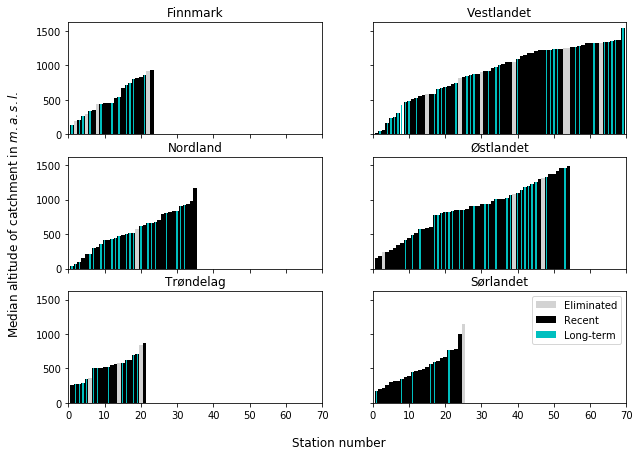

In [32]:
# with subplotting version 2
fig,ax = plt.subplots(nrows = 3,ncols = 2,sharex = True,sharey=True,figsize=(10,7))
plt.xlim(0,70)

for i in range(len(data.keys())):
    reg = list(data.keys())[i]
    df = data[reg]
    dfr30 = df["metadata"][df["metadata"].snumber.isin(df[f"final30"])]
    dfr50 = df["metadata"][df["metadata"].snumber.isin(df[f"final50"])]
    rm = df["metadata"][~df["metadata"].snumber.isin(df[f"final50"])]
    if i < 3:
        ax[i][0].bar(rm["station.order"],rm["altitude"],width=1,color="lightgrey",label="Eliminated")
        ax[i][0].bar(dfr30["station.order"],dfr30["altitude"],width=1,color="k",label="Selected 30year")
        ax[i][0].bar(dfr50["station.order"],dfr50["altitude"],width=0.4,color="c",label="Selected 50year")
        ax[i][0].set_title(regionLabels[reg])
    else:
        ax[i-3][1].bar(rm["station.order"],rm["altitude"],width=1,color="lightgrey",label="Eliminated")
        ax[i-3][1].bar(dfr30["station.order"],dfr30["altitude"],width=1,color="k",label="Recent")
        ax[i-3][1].bar(dfr50["station.order"],dfr50["altitude"],width=0.4,color="c",label="Long-term")
        ax[i-3][1].set_title(regionLabels[reg])
        
fig.text(0.5, 0.04, "Station number", ha="center",fontsize=12)
fig.text(0.04, 0.5, "Median altitude of catchment in $m.a.s.l.$", va="center", rotation="vertical",fontsize=12)
plt.legend()
fig.savefig(f"Plots/elevation_selectedStations2_final",dpi=400,bbox_inches='tight')

In [33]:
marker = itertools.cycle(("v", "x", "+", "D", "^","."))
for label, dfr in newFinalSelection30.groupby("runoff.region"):
    plt.figure()
    plt.hist(dfr.altitude,color="grey")
    plt.title(label)
    plt.xlabel("Elevation in $m$")
    plt.ylabel("Frequency")
    plt.savefig(f"Plots/final_hist_{label}_altitude.png",dpi=400,bbox_inches='tight')
    plt.close()

In [34]:
for label, dfr in newFinalSelection30.groupby("runoff.region"):
    plt.plot(dfr.areal,dfr.altitude,".",marker=next(marker),label=regionLabels[label])
plt.ylabel("Elevation in $m$")
plt.xlabel("Area")
plt.legend()
plt.savefig("Plots/final_scatter_altitude_area_30year.png",dpi=400,bbox_inches='tight')

plt.figure()
for label, dfr in newFinalSelection50.groupby("runoff.region"):
    plt.plot(dfr.areal,dfr.altitude,".",marker=next(marker),label=regionLabels[label])
plt.ylabel("Elevation in $m$")
plt.xlabel("Area")
plt.legend()
plt.savefig("Plots/final_scatter_altitude_area_50year.png",dpi=400,bbox_inches='tight')

KeyError: 'finnmark'

In [35]:
colors = itertools.cycle(("c", "darkslategrey"))
plt.figure(figsize=(5,10))
for label, df in newFinalSelection30.groupby("runoff.region"):
    plt.plot(df.altitude,df.lat,".",marker=next(marker),label=regionLabels[label],color=next(colors))
plt.xlabel("Elevation in $m$")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("Plots/final_scatter_lat_altitude_30year.png",dpi=400,bbox_inches='tight')

KeyError: 'finnmark'

<Figure size 360x720 with 0 Axes>

In [36]:
for label, df in newFinalSelection30.groupby("runoff.region"):
    plt.plot(df.areal,df.lat,".",marker=next(marker),label=regionLabels[label])
plt.xlabel("Area")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("Plots/final_scatter_lat_area_30year.png",dpi=400,bbox_inches='tight')

KeyError: 'finnmark'

In [ ]:
def plotRunoffLengthFinal(data,title,filename):
    cmap=plt.cm.get_cmap("RdYlGn_r")
    a = missingDaysRegion(data)
    plt.figure(figsize=(15,a.shape[0]/10))
    # if more than 30 days are missing, they are red
    plt.imshow(a,cmap=cmap,vmin=0,vmax=366,aspect=1.5)
    plt.xlabel("Years")
    plt.xticks(range(-1,145,10),range(1870,2014,10))
    plt.ylabel("Station ordered by altitude")
    cbar = plt.colorbar(shrink=1/(a.shape[0])*20, label="Missing days per year")
    cbar.ax.invert_yaxis()
    plt.title(title)
    for i in range(len(data["order"])):
        if data["order"][i] not in data["final50"]:
            plt.axhline(i,color="lightgrey",xmin=(1963-1870)/144,xmax=(1982-1870)/144,linewidth=3,label="Removed from 30 year analysis")
    for i in range(len(data["order"])):
        if data["order"][i] not in data["final30"]:
            plt.axhline(i,color="grey",xmin=(1983-1870)/144,linewidth=3)
    plt.savefig(f"Plots/runoffLengthFinal_{filename}.png",dpi=300,bbox_inches='tight')

In [ ]:
legend_elements = [Line2D([0], [0], color="grey",label="Recent"),
                       Line2D([0], [0], color="lightgrey",label="Long-term analysis")]
plt.legend(handles=legend_elements, loc="center",title="Cathcment eliminated from:                       ",ncol=2)
plt.savefig(f"Plots/runoffLengthFinal_legend.png",dpi=300,bbox_inches='tight')

In [ ]:
plotRunoffLengthFinal(sor,"Sørlandet","sorlandet")
plotRunoffLengthFinal(ost,"Østlandet","ostlandet")
plotRunoffLengthFinal(vest,"Vestlandet","vestlandet")
plotRunoffLengthFinal(nord,"Nordland","nordland")
plotRunoffLengthFinal(trond,"Trøndelag","trondelag")
plotRunoffLengthFinal(finn,"Finnmark","finnmark")

## Map

In [ ]:
norge = gpd.read_file("gis/Norge.shp")
regionLines = gpd.read_file("gis/Grense_Avrenningsregioner.shp")
stations = gpd.read_file("gis/Gauging_Stations.shp")

In [ ]:
regine = list(newFinalSelection30.regine)
main = list(newFinalSelection30.main)
station30 = []
for i in range(len(regine)):
    station30.append(f"{str(regine[i])}.{str(main[i])}")

regine = list(removedCatchm30.regine)
main = list(removedCatchm30.main)
removed30 = []
for i in range(len(regine)):
    removed30.append(f"{str(regine[i])}.{str(main[i])}")
    
regine = list(newFinalSelection50.regine)
main = list(newFinalSelection50.main)
station50 = []
for i in range(len(regine)):
    station50.append(f"{str(regine[i])}.{str(main[i])}")

In [ ]:
mask = stations.STASJON_NR.isin(station30)
stations30 = stations[mask]
mask = stations.STASJON_NR.isin(removed30)
rstations30 = stations[mask]
mask = stations.STASJON_NR.isin(station50)
stations50 = stations[mask]

In [ ]:
fig,ax = plt.subplots(figsize=(30,10))
norge.plot(ax=ax,color="white", edgecolor="lightgrey")
regionLines.plot(ax=ax,color="darksalmon",label="Runoff region")
rstations30.plot(ax=ax,color="grey",marker="x",markersize=20,label="Removed")
stations30.plot(ax=ax,marker="v",markersize=40,color="k",label="Recent",alpha=.8)
stations50.plot(ax=ax,marker="^",markersize=40,color="c",label="Long-term",alpha=.8)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklines(), visible=False)
plt.setp(ax.get_yticklines(), visible=False)
plt.setp(ax.spines.values(), visible=False)
plt.legend(loc="upper left")
plt.savefig("Plots/final&removed_map.png",dpi=400,bbox_inches='tight')

## Moving average

### Window comparison

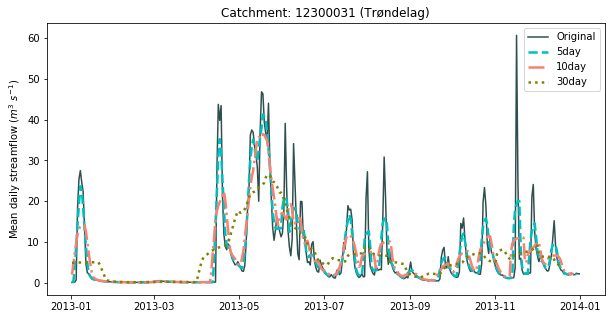

In [46]:
catchm = trond["final30"][5]
runoff = trond["data"][catchm]["runoff"]

# moving average with different window sizes
runoff5day = runoff.rolling(5,center=True).mean()
runoff10day = runoff.rolling(10,center=True).mean()
runoff15day = runoff.rolling(15,center=True).mean()
runoff20day = runoff.rolling(20,center=True).mean()
runoff30day = runoff.rolling(30,center=True).mean()

line = itertools.cycle(("--","-.",":"))
colors = itertools.cycle(("c","salmon","olive"))

# plotting
plt.figure(figsize=(10,5))
plt.plot(runoff.runoff["2013"],"darkslategray",label="Original")
plt.plot(runoff5day.runoff["2013"],next(line),linewidth=2.5,color=next(colors),label="5day")
plt.plot(runoff10day.runoff["2013"],next(line),linewidth=2.5,color=next(colors),label="10day")
#plt.plot(runoff15day.runoff[-365:],next(line),linewidth=2.5,color=next(colors),label="15day")
#plt.plot(runoff20day.runoff[-365:],next(line),linewidth=2.5,color=next(colors),label="20day")
plt.plot(runoff30day.runoff["2013"],next(line),linewidth=2.5,color=next(colors),label="30day")
plt.ylabel("Mean daily streamflow ($m^3 \ s^{-1}$)")
plt.title(f"Catchment: {catchm} (Trøndelag)")
plt.legend()
plt.savefig("Plots/movingAverage_example_streamflow.png",dpi=400,bbox_inches='tight')

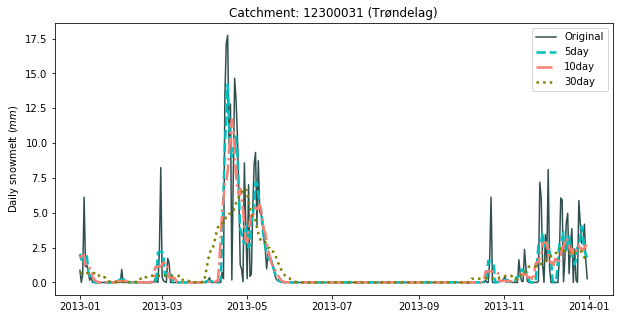

In [45]:
catchm = trond["final30"][5]
runoff = trond["data"][catchm]["snow"]

# moving average with different window sizes
runoff5day = runoff.rolling(5,center=True).mean()
runoff10day = runoff.rolling(10,center=True).mean()
runoff15day = runoff.rolling(15,center=True).mean()
runoff20day = runoff.rolling(20,center=True).mean()
runoff30day = runoff.rolling(30,center=True).mean()

line = itertools.cycle(("--","-.",":"))
colors = itertools.cycle(("c","salmon","olive"))

# plotting
plt.figure(figsize=(10,5))
plt.plot(runoff["2013"],"darkslategray",label="Original")
plt.plot(runoff5day["2013"],next(line),linewidth=2.5,color=next(colors),label="5day")
plt.plot(runoff10day["2013"],next(line),linewidth=2.5,color=next(colors),label="10day")
#plt.plot(runoff15day.runoff[-365:],next(line),linewidth=2.5,color=next(colors),label="15day")
#plt.plot(runoff20day.runoff[-365:],next(line),linewidth=2.5,color=next(colors),label="20day")
plt.plot(runoff30day["2013"],next(line),linewidth=2.5,color=next(colors),label="30day")
plt.ylabel("Daily snowmelt ($mm$)")
plt.title(f"Catchment: {catchm} (Trøndelag)")
plt.legend()
plt.savefig("Plots/movingAverage_example_snowmelt.png",dpi=400,bbox_inches='tight')

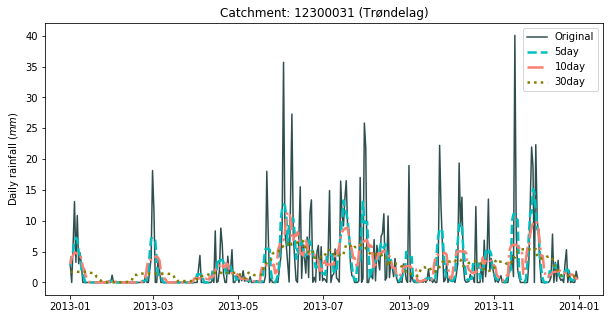

In [47]:
catchm = trond["final30"][5]
runoff = trond["data"][catchm]["precip"]

# moving average with different window sizes
runoff5day = runoff.rolling(5,center=True).mean()
runoff10day = runoff.rolling(10,center=True).mean()
runoff15day = runoff.rolling(15,center=True).mean()
runoff20day = runoff.rolling(20,center=True).mean()
runoff30day = runoff.rolling(30,center=True).mean()

line = itertools.cycle(("--","-.",":"))
colors = itertools.cycle(("c","salmon","olive"))

# plotting
plt.figure(figsize=(10,5))
plt.plot(runoff["2013"],"darkslategray",label="Original")
plt.plot(runoff5day["2013"],next(line),linewidth=2.5,color=next(colors),label="5day")
plt.plot(runoff10day["2013"],next(line),linewidth=2.5,color=next(colors),label="10day")
#plt.plot(runoff15day.runoff[-365:],next(line),linewidth=2.5,color=next(colors),label="15day")
#plt.plot(runoff20day.runoff[-365:],next(line),linewidth=2.5,color=next(colors),label="20day")
plt.plot(runoff30day["2013"],next(line),linewidth=2.5,color=next(colors),label="30day")
plt.ylabel("Daily rainfall ($mm$)")
plt.title(f"Catchment: {catchm} (Trøndelag)")
plt.legend()
plt.savefig("Plots/movingAverage_example_rainfall.png",dpi=400,bbox_inches='tight')

### Extract timeseries

In [ ]:
def extractMA(timeseries, interval, startYear=1983, endYear = 2012):
    """
    Exstracts moving average timeseries in given timeperiod 
    
    Parameters
    ----------
    timeseries: 
        a pandas timeseries, with datetime index
    interval: int
        number of days in window
    startYear: int
        start of timeseries
    endYear: int
        end of timeseries
        
    Returns
    -------
    timeseries for given years
    """
    start = datetime.datetime(startYear,1,1)
    end = datetime.datetime(endYear,12,31)
    
    series = timeseries.rolling(interval,center=True).mean()
    
    return series[start:end]

#### Runoff

In [ ]:
r = ["ost","vest","sor","nord","trond","finn"]
data = [ost,vest,sor,nord,trond,finn]
data = dict(zip(r,data))

"""runoff30 = {}
for region in data.keys():
    runoff30yr = {}
    d = data[region]
    for c in d["final"]:
        ts = d["data"][c]["runoff"]
        runoff30yr[c] = {}
        runoff30yr[c]["5day"] = extractMA(ts, interval = 5).runoff
        runoff30yr[c]["10day"] = extractMA(ts, interval = 10).runoff
        runoff30yr[c]["30day"] = extractMA(ts, interval = 30).runoff
    
    runoff30[region] = runoff30yr"""

spesRunoff30 = {}
for region in data.keys():
    runoff30yr = {}
    d = data[region]
    meta = d["metadata"]
    for c in d["final30"]:
        area = float(d["metadata"][d["metadata"].snumber==c].areal)
        ts = d["data"][c]["runoff"]/area
        runoff30yr[c] = {}
        runoff30yr[c]["5day"] = extractMA(ts, interval = 5).runoff/area
        runoff30yr[c]["10day"] = extractMA(ts, interval = 10).runoff/area
        runoff30yr[c]["30day"] = extractMA(ts, interval = 30).runoff/area
    
    spesRunoff30[region] = runoff30yr
    
"""runoff50 = {}
for region in data.keys():
    runoff30yr = {}
    d = data[region]
    for c in d["final"]:
        ts = d["data"][c]["runoff"]
        runoff30yr[c] = {}
        runoff30yr[c]["5day"] = extractMA(ts, interval = 5, startYear=1963).runoff
        runoff30yr[c]["10day"] = extractMA(ts, interval = 10, startYear=1963).runoff
        runoff30yr[c]["30day"] = extractMA(ts, interval = 30, startYear=1963).runoff
    
    runoff50[region] = runoff30yr"""

spesRunoff50 = {}
for region in data.keys():
    runoff30yr = {}
    d = data[region]
    meta = d["metadata"]
    for c in d["final50"]:
        area = float(d["metadata"][d["metadata"].snumber==c].areal)
        ts = d["data"][c]["runoff"]/area
        runoff30yr[c] = {}
        runoff30yr[c]["5day"] = extractMA(ts, interval = 5, startYear=1963).runoff/area
        runoff30yr[c]["10day"] = extractMA(ts, interval = 10, startYear=1963).runoff/area
        runoff30yr[c]["30day"] = extractMA(ts, interval = 30, startYear=1963).runoff/area
    
    spesRunoff50[region] = runoff30yr

#### Temperature

In [ ]:
temp30 = {}
for region in data.keys():
    temp30yr = {}
    d = data[region]
    for c in d["final30"]:
        ts = d["data"][c]["temp"]
        temp30yr[c] = {}
        temp30yr[c]["5day"] = extractMA(ts, interval = 5)
        temp30yr[c]["10day"] = extractMA(ts, interval = 10)
        temp30yr[c]["30day"] = extractMA(ts, interval = 30)
    
    temp30[region] = temp30yr
    
temp50 = {}
for region in data.keys():
    temp30yr = {}
    d = data[region]
    for c in d["final50"]:
        ts = d["data"][c]["temp"]
        temp30yr[c] = {}
        temp30yr[c]["5day"] = extractMA(ts, interval = 5, startYear=1963)
        temp30yr[c]["10day"] = extractMA(ts, interval = 10, startYear=1963)
        temp30yr[c]["30day"] = extractMA(ts, interval = 30, startYear=1963)
    
    temp50[region] = temp30yr

#### Rainfall

**OBS!** "Precipitation" is possibly only rainfall data

How should it be smoothed? Does MA makes sense?

In [ ]:
rainfall30 = {}
for region in data.keys():
    rainfall30yr = {}
    d = data[region]
    for c in d["final30"]:
        ts = d["data"][c]["precip"]
        rainfall30yr[c] = {}
        rainfall30yr[c]["5day"] = extractMA(ts, interval = 5)
        rainfall30yr[c]["10day"] = extractMA(ts, interval = 10)
        rainfall30yr[c]["30day"] = extractMA(ts, interval = 30)
    
    rainfall30[region] = rainfall30yr
    
rainfall50 = {}
for region in data.keys():
    rainfall30yr = {}
    d = data[region]
    for c in d["final50"]:
        ts = d["data"][c]["precip"]
        rainfall30yr[c] = {}
        rainfall30yr[c]["5day"] = extractMA(ts, interval = 5, startYear=1963)
        rainfall30yr[c]["10day"] = extractMA(ts, interval = 10, startYear=1963)
        rainfall30yr[c]["30day"] = extractMA(ts, interval = 30, startYear=1963)
    
    rainfall50[region] = rainfall30yr

#### Snowmelt

In [ ]:
snow30 = {}
for region in data.keys():
    snow30yr = {}
    d = data[region]
    for c in d["final30"]:
        ts = d["data"][c]["snow"]
        snow30yr[c] = {}
        snow30yr[c]["5day"] = extractMA(ts, interval = 5).qsw
        snow30yr[c]["10day"] = extractMA(ts, interval = 10).qsw
        snow30yr[c]["30day"] = extractMA(ts, interval = 30).qsw
    
    snow30[region] = snow30yr
    
snow50 = {}
for region in data.keys():
    snow30yr = {}
    d = data[region]
    for c in d["final50"]:
        ts = d["data"][c]["snow"]
        snow30yr[c] = {}
        snow30yr[c]["5day"] = extractMA(ts, interval = 5, startYear=1963).qsw
        snow30yr[c]["10day"] = extractMA(ts, interval = 10, startYear=1963).qsw
        snow30yr[c]["30day"] = extractMA(ts, interval = 30, startYear=1963).qsw
    
    snow50[region] = snow30yr

### Saving to file

In [ ]:
saveDict(snow30,"MA_snowmelt_30year")
saveDict(snow50,"MA_snowmelt_50year")
saveDict(rainfall30,"MA_rainfall_30year")
saveDict(rainfall50,"MA_rainfall_50year")
saveDict(temp30,"MA_temperature_30year")
saveDict(temp50,"MA_temperature_50year")
saveDict(spesRunoff30,"MA_streamflow_30year")
saveDict(spesRunoff50,"MA_streamflow_50year")